# Teil I zum Praktischen Teil der Bachelorarbeit zum Thema 
## Dynamic Pricing in der Luftfahrt: Analyse von Machine-Learning-Algorithmen zur Vorhersage von Flugpreisen
#### Von Dominik Lewin, Matrikelnummer 3274837

In diesem ersten Jupyter Notebook wird es darum gehen, einen ersten Einblick in die vorhandenen Daten zu geben. Es erfolgt eine explorative Datenanalyse anhand des Datensatzes, wobei unter anderem verschiedene statistische Lagemaße berechnet werden und die Ergebnisse visualisiert werden. 

Im zweiten Jupyter Notebook wird es schließlich um die Machine-Learning-Algorithmen gehen, die trainiert, optimiert und getestet werden sollen. 


# Inhaltsverzeichnis

* [1. Erster Überblick über den Datensatz](#ueberblick)
* [2. Die Aufgabe abstecken](#aufgabe)
* [3. Erkundung der Daten](#erkundung)
    * [3.1. Airlines](#airlines)
    * [3.2. Überprüfung der NaN-Werte](#nan)
    * [3.3. Statistische Lagemaße](#statistik)
    * [3.4. Visualisierung der Daten](#visualisierung)
    * [3.5. Untersuchung der Wochentage](#wochentage)
    * [3.6. Untersuchung des Preisverhaltens im Zeitverlauf](#preisverhalten)
    * [3.7. Korrelationen](#korrelation)
    * [3.8. Graphische Übersicht](#grafik)

## 1. Erster Überblick über den Datensatz <a class="anchor" id="ueberblick"></a>

Hierfür werden zunächst die Daten eingelesen.

In [1]:
#Pakete importieren
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from datetime import time
from datetime import datetime
pd.options.mode.chained_assignment = None

In [2]:
#Einlesen des Datensatzes. Die beiden Kalenderdaten werden direkt im richtigen Format eingelesen.
data = pd.read_csv("flight_price_data.csv", 
                sep=";", 
                parse_dates=["Buchungsdatum", "Abflugdatum"])

#Funktion, um die Zeiten von Strings in datetime.time-Objekte umzuwandeln
def konvertiere(zeit_string):
    zeit = datetime.strptime(zeit_string, "%H:%M:%S").time()
    return zeit

#Wende die Funktion auf die Abflugzeit und Ankunftszeit an
data["Abflugzeit"] = data["Abflugzeit"].apply(konvertiere)
data["Ankunftszeit"] = data["Ankunftszeit"].apply(konvertiere)

data

,Buchungsdatum,Abflugdatum,Abflughafen,Zielflughafen,Abflugzeit,Ankunftszeit,Preis,Flugnummer,Airline
0,2022-11-09,2023-02-26,HAM,LHR,17:55:00,18:40:00,98.0,EW 7460,Eurowings
1,2022-11-10,2023-02-26,HAM,LHR,17:55:00,18:40:00,98.0,EW 7460,Eurowings
2,2022-11-11,2023-02-26,HAM,LHR,17:55:00,18:40:00,98.0,EW 7460,Eurowings
3,2022-11-12,2023-02-26,HAM,LHR,17:55:00,18:40:00,98.0,EW 7460,Eurowings
4,2022-11-13,2023-02-26,HAM,LHR,17:55:00,18:40:00,98.0,EW 7460,Eurowings
...,...,...,...,...,...,...,...,...,...
47228,2023-03-24,2023-03-25,HAM,LHR,07:20:00,08:10:00,370.0,EW 7464,Eurowings
47229,2023-03-24,2023-03-25,HAM,LHR,15:20:00,16:05:00,340.0,BA 975,British Airways
47230,2023-03-24,2023-03-25,HAM,LHR,10:25:00,11:20:00,927.0,BA 965,British Airways
47231,2023-03-24,2023-03-25,HAM,LHR,06:40:00,07:25:00,NaN,BA 963,British Airways


Der Datensatz besteht aus folgenden Merkmalen:

- Buchungsdatum
- Abflugdatum
- Abflughafen
- Zielflughafen
- Abflugzeit
- Ankunftszeit
- Preis
- Flugnummer
- Airline

In [3]:
#Überblick über die Daten und deren Datentypen verschaffen
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47233 entries, 0 to 47232
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Buchungsdatum  47233 non-null  datetime64[ns]
 1   Abflugdatum    47233 non-null  datetime64[ns]
 2   Abflughafen    47233 non-null  object        
 3   Zielflughafen  47233 non-null  object        
 4   Abflugzeit     47233 non-null  object        
 5   Ankunftszeit   47233 non-null  object        
 6   Preis          47187 non-null  float64       
 7   Flugnummer     47233 non-null  object        
 8   Airline        47233 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 3.2+ MB


Der Datensatz hat 47233 Einträge mit den Indizes 0 bis 47232. Es gibt 9 Spalten, dies sind die eben genannten Merkmale.

Für den *Preis* sind nicht alle Daten vollständig. Hier müssen nicht vorhandene Werte ersetzt oder verworfen werden. Es gibt nur 47187 vorhandene Einträge, demnach fehlen 46 Werte. Dies kann darauf zurückzuführen sein, dass einige Flüge zum Zeitpunkt der Datenerfassung bereits einige Tage vor Abflug ausgebucht waren und daher kein Preis mehr verfügbar war. Außerdem wurde ein Streik angesagt, weshalb ebenfalls keine Preise vorhanden waren.

Ansonsten sind alle Daten vollständig. 

## 2. Die Aufgabe abstecken <a class="anchor" id="aufgabe"></a>

Es gibt zwei Ziele, die mit Hilfe von Machine Learning umgesetzt werden sollen:
1. Es soll für einen bestimmten Flug der niedrigste zu erwartende Preis vorhergesagt werden (Regressionsproblem).
2. Es soll eine Empfehlung ausgesprochen werden, ob ein bestimmter Flug gebucht werden soll oder ob dieser künftig voraussichtlich günstiger angeboten wird (Klassifikationsproblem).

## 3. Erkundung der Daten <a class="anchor" id="erkundung"></a>

## 3.1. Airlines <a class="anchor" id="airlines"></a>

Bei dem Merkmal *Airline* handelt es sich um ein kategorisches Merkmal, das sich aus den vier Airlines zusammensetzt. Die Anzahl der verfügbaren Flugpreise wird je Airline dargestellt:

In [4]:
data["Airline"].value_counts()

British Airways    25528
Eurowings          12355
Ryanair             5015
easyJet             4335
Name: Airline, dtype: int64

Es ist zu erkennen, dass die meisten Flugpreise von British Airways und die wenigsten Flugpreise von easyJet kommen. Es soll nun überprüft werden, ob dies daran liegt, dass für British Airways eine längere Zeitperiode aufgezeichnet wurde oder ob generell mehr Flüge stattgefunden haben. Hierfür kann jeder einzelne Flug durch die Kombination aus *Abflugdatum* und *Flugnummer* identifiziert werden.

In [5]:
#Datensatz gruppieren nach Abflugdatum und Flugnummer
fluege = data.groupby(["Abflugdatum", "Flugnummer", "Airline"]).size()
fluege.head()

Abflugdatum  Flugnummer  Airline        
2023-02-26   BA 967      British Airways    251
             EW 7460     Eurowings          109
             EW 7462     Eurowings          119
2023-02-27   BA 957      British Airways      7
             BA 963      British Airways    155
dtype: int64

In [6]:
#Daten nach Airline filtern, um die Anzahl der Flüge anzuzeigen
fluege.groupby("Airline").size()

Airline
British Airways    122
Eurowings           71
Ryanair             22
easyJet             22
dtype: int64

Es ist ersichtlich, dass British Airways tatsächlich die deutliche Mehrheit der Flüge angeboten hat und Ryanair und easyJet die wenigsten Flüge angeboten haben. 

## 3.2. Überprüfung der NaN-Werte <a class="anchor" id="nan"></a>

Als nächstes werden die NaN-Werte überprüft, um eine mögliche Entfernung oder Ersetzung abzuwägen. Dieser Schritt gehört streng genommen bereits zur Datenaufbereitung, allerdings ist eine explorative Datenanalyse nicht möglich, solange NaN-Werte vorhanden sind, da beispielsweise der Mittelwert nicht bestimmt werden kann.

In [7]:
data[data["Preis"].isna()]

,Buchungsdatum,Abflugdatum,Abflughafen,Zielflughafen,Abflugzeit,Ankunftszeit,Preis,Flugnummer,Airline
11004,2023-01-28,2023-03-05,HAM,LHR,06:45:00,07:30:00,NaN,BA 963,British Airways
11005,2023-01-29,2023-03-05,HAM,LHR,06:45:00,07:30:00,NaN,BA 963,British Airways
11006,2023-01-30,2023-03-05,HAM,LHR,06:45:00,07:30:00,NaN,BA 963,British Airways
11007,2023-01-31,2023-03-05,HAM,LHR,06:45:00,07:30:00,NaN,BA 963,British Airways
11008,2023-02-01,2023-03-05,HAM,LHR,06:45:00,07:30:00,NaN,BA 963,British Airways
11009,2023-02-02,2023-03-05,HAM,LHR,06:45:00,07:30:00,NaN,BA 963,British Airways
11010,2023-02-03,2023-03-05,HAM,LHR,06:45:00,07:30:00,NaN,BA 963,British Airways
11011,2023-02-04,2023-03-05,HAM,LHR,06:45:00,07:30:00,NaN,BA 963,British Airways
11012,2023-02-05,2023-03-05,HAM,LHR,06:45:00,07:30:00,NaN,BA 963,British Airways
11013,2023-02-06,2023-03-05,HAM,LHR,06:45:00,07:30:00,NaN,BA 963,British Airways


Es fällt auf, dass der Großteil aller fehlender Flugpreise derselbe Flug ist. Offensichtlich gab es bei der Aufzeichnung eine große Lücke. Da hier zu viele Werte fehlen, macht eine Ersetzung mit einem Durchschnittswert wenig Sinn. Daher werden alle Zeilen des Fluges vom 05.02.2023 mit der Flugnummer BA 963, die NaN-Werte enthalten komplett aus dem Datensatz entfernt.

Bei den weiteren Flügen mit Abflug am 13.03.2023 handelt es sich um Flüge, die aufgrund eines Streiks gestrichen wurden. Bei den beiden Flügen mit Abflug am 25.03.2023 handelt es sich um Flüge, die einen Tag vor Abflug bereits ausgebucht waren und nicht mehr buchbar waren. Da es sich nur um eine geringe Anzahl an Flügen handelt, ist zu prüfen, ob und wie diese ersetzt werden können.

Um den Datensatz genauer untersuchen zu können, wird zunächst ein neuer Datensatz erzeugt, der die bisherigen Daten um drei Merkmale erweitert: *Wochentag der Buchung*, *Wochentag des Abflugs* und *Tage bis Abflug*. Zudem werden NaN-Werte des Merkmals *Preis* wie zuvor beschrieben entfernt oder ersetzt und anschließend in int-Werte umgewandelt, um statistische Berechnungen durchführen zu können.

In [8]:
#Um den über den Umgang mit fehlenden Werten zu entscheiden, wird zunächst eine Kopie
#des Datensatzes erzeugt, in der alle NaN-Werte entfernt wurden und der Preis als int-Wert gespeichert wird.
df = data.dropna()
df["Preis"] = df["Preis"].astype(int)

#Hinzufügen der weiteren Attribute
#Wochentage hinzufügen. 0 = Montag, 6 = Sonntag
df["Wochentag der Buchung"] = df["Buchungsdatum"].dt.dayofweek
df["Wochentag des Abflugs"] = df["Abflugdatum"].dt.dayofweek

#Tage bis Abflug hinzufügen
df["Tage bis Abflug"] = df["Abflugdatum"]-df["Buchungsdatum"]
df["Tage bis Abflug"] = pd.to_timedelta(df["Tage bis Abflug"]).dt.days
df.head()

,Buchungsdatum,Abflugdatum,Abflughafen,Zielflughafen,Abflugzeit,Ankunftszeit,Preis,Flugnummer,Airline,Wochentag der Buchung,Wochentag des Abflugs,Tage bis Abflug
0,2022-11-09,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,2,6,109
1,2022-11-10,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,3,6,108
2,2022-11-11,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,4,6,107
3,2022-11-12,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,5,6,106
4,2022-11-13,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,6,6,105


Bei den fehlenden Flugpreisen handelt es sich nur um den Flugpreis einen Tag vor Abflug. Die Preise zwei Tage vor Abflug sind für alle Flüge vorhanden. Es stellt sich die Frage, um wie viel Euro der Preis einen Tag vor Abflug im Verlgeich zum Preis zwei Tage vor Abflug im Durchschnitt steigt. Anschließend kann der fehlende Wert ggf. ersetzt werden, indem der Flugpreis (der Preis zwei Tage vor Abflug) um die durchschnittliche Erhöhung angepasst wird. Es ist sinnvoll, die Airlines einzeln zu betrachten, da jede Airline ihre eigene Preisstrategie führt.

In [9]:
import numpy as np

#Bestimme für eine Airline den durchschnittlichen aufgerundeten Erhöhungsbetrag zwischen dem Preis
#zwei Tage vor Abflug zum Preis einen Tag vor Abflug, sofern im Datensatz beides vorhanden ist.
def bestimme_erhoehungsbetrag(datensatz, airline):
    
    #Betrachtet werden nur die Preise einen und zwei Tage vor Abflug einer bestimmten Airline
    neue_daten = datensatz[((datensatz["Tage bis Abflug"] < 3) & (datensatz["Airline"] == airline))]
    
    #Daten sortieren, damit immer zwei zusammgengehörige Flüge hintereinander vorkommen
    neue_daten.sort_values(["Flugnummer", "Abflugdatum", "Tage bis Abflug"], inplace=True)
        
    liste = []
    #Gehe jeden Datenpunkt durch und prüfe, ob zwei aufeinanderfolgende Datenpunkte zusammengehören
    for i in range(len(neue_daten)):
        if(i != len(neue_daten)-1):
            if ((neue_daten.iloc[i]["Abflugdatum"] == neue_daten.iloc[i+1]["Abflugdatum"]) & 
            (neue_daten.iloc[i]["Flugnummer"] == neue_daten.iloc[i+1]["Flugnummer"])):
                #Falls zwei Datenpunkte zusammengehören (gleicher Flug), bestimme den Preisunterschied
                #und speicher diesen in einer Liste
                liste.append(neue_daten.iloc[i]["Preis"] - neue_daten.iloc[i+1]["Preis"])
    neueliste = np.array(liste)
    print(neueliste)
    print("Anzahl der betrachteten Flüge: ", len(neueliste))
    #Gib die aufgerundete durchschnittliche Flugpreiserhöhung zurück
    return round(neueliste.mean())

In [10]:
#Bestimme für jede Airline die durchschnittliche Flugpreiserhöhung des Preises zwei Tage vor Abflug
#zum Preis einen Tag vor Abflug
print("Flugpreisänderungen der verschiedenen Airlines")
for airline in df["Airline"].unique():
    print(airline, ":")
    print("Durchschnittliche Preisänderung: ", bestimme_erhoehungsbetrag(df, airline), "Euro")
    print()

Flugpreisänderungen der verschiedenen Airlines
Eurowings :
[  0   0  20   0  41  51   0   0   0   0   1  36   0  80  14   0 110   0
   0   0   0   0   0  21  20  20   1  51   0   1   0  21  20  10 141  -6
   0 190   0   0   0   0  14   1   1  20   0   1  71   1 -11 -19  21   9
  21  51  13  20  20  20   1   1 -15  20  51]
Anzahl der betrachteten Flüge:  65
Durchschnittliche Preisänderung:  18 Euro

British Airways :
[ 199  115    0  158 -151   79   10  -96   70   76  347  120   27   84
   55  221    0 -483  -65    4 -103   -8   51   49  127   27  160  133
    0    0   73    9  235  190  486  282  -73  322   40 -141    0   71
    0  109   36 -103    0    4   58  243  274   57   46   49  -13  346
  129  248  103  409    0   48   49   36   46   61  152    0  103  396
   17   76   72  247    0  103    5  212  242   55  248   46   69   40
  101  313    0   61   18   12   90    0  -15   -7  347   55 -167  -27
    0    9 -210]
Anzahl der betrachteten Flüge:  101
Durchschnittliche Preisänderun

An dieser Stelle fällt auf, dass es weitere Flüge gibt, die einen Tag vor Abflug bereits ausgebucht waren, aber nicht im Datensatz auftauchen, auch nicht mit NaN-Wert. Dies sieht man beispielsweise an den Flügen von British Airways. Insgesamt gibt es 122 Flüge, aber einen Tag vor Abflug waren nur 101 Flüge im Datensatz vorhanden.

Auch fällt auf, dass die Preisdifferenzen zu unterschiedlich sind, um einfach die fehlenden Werte mit dem Durschnitt zu ersetzen. 

Zudem ist es üblich, dass Flüge einen Tag vor Abflug bereits ausgebucht sein können, weshalb es wenig Sinn ergibt, nicht vorhandene Flüge mit Durchschnittswerten zu ersetzen. 

Aufgrund der genannten Anmerkungen werden im Folgenden alle Zeilen mit NaN-Werten entfernt und nicht ersetzt. Der bisherige (kopierte und bearbeitete) Datensatz kann dementsprechend beibehalten werden, da keine NaN-Werte mehr enthalten sind.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47187 entries, 0 to 47230
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Buchungsdatum          47187 non-null  datetime64[ns]
 1   Abflugdatum            47187 non-null  datetime64[ns]
 2   Abflughafen            47187 non-null  object        
 3   Zielflughafen          47187 non-null  object        
 4   Abflugzeit             47187 non-null  object        
 5   Ankunftszeit           47187 non-null  object        
 6   Preis                  47187 non-null  int64         
 7   Flugnummer             47187 non-null  object        
 8   Airline                47187 non-null  object        
 9   Wochentag der Buchung  47187 non-null  int64         
 10  Wochentag des Abflugs  47187 non-null  int64         
 11  Tage bis Abflug        47187 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(6)
memory usage: 4.7+

## 3.3. Statistische Lagemaße <a class="anchor" id="statistik"></a>

Für numerische Attribute der Verhältnisskala (Preis und Tage bis Abflug) können statistische Parameter wie Anzahl, Mittelwert, Standardabweichung, Minimum und Maximum betrachtet werden. Die Wochentage sind zwar auch als numerischer Wert gespeichert, allerdings stehen die Werte 0 bis 7 für die nominalen Attribute Montag bis Sonntag. Dementsprechend ist eine Mittelwertbestimmung sinnlos. 

In [12]:
df[["Preis", "Tage bis Abflug"]].describe()

,Preis,Tage bis Abflug
count,47187.000000,47187.000000
mean,77.525759,117.635048
std,62.554385,78.812569
min,17.000000,1.000000
25%,49.000000,53.000000
50%,67.000000,107.000000
75%,85.000000,170.000000
max,927.000000,381.000000


In [13]:
#Median und Modalwert für den Preis bestimmen
print("Median:    ", df["Preis"].median())
print("Modalwert: ", float(df["Preis"].mode()[0]))

Median:     67.0
Modalwert:  58.0


Es ist zu erkennen, dass die Flüge zwischen einem Tag vor Abflug und 381 Tage vor Abflug aufgezeichnet wurden. Auch ist zu erkennen, dass der Durchschnittspreis bei ca. 78 Euro lag, mit einer Standardabweichung von ca. 63 Euro. 75% aller Flüge lagen bei unter 85 Euro. Die Preise liegen zwischen 17 Euro und 927 Euro. Interessant ist, ob der Durchschnittspreis je Airline deutlich vom o.g. Mittelwert abweicht. Um dies zu überprüfen, wird die Berechnung für alle Airlines einzeln durchgeführt. Zudem werden auch Median und Modalwert bestimmt.

In [14]:
for airline in df["Airline"].unique():
    print(airline, ":")
    print("Median:    ", df[df["Airline"] == airline]["Preis"].median())
    print("Modalwert: ", float(df[df["Airline"] == airline]["Preis"].mode()[0]))
    display(df[df["Airline"] == airline]["Preis"].describe())
    print()

Eurowings :
Median:     79.0
Modalwert:  80.0


count    12352.000000
mean        85.934343
std         34.455055
min         38.000000
25%         60.000000
50%         79.000000
75%        100.000000
max        420.000000
Name: Preis, dtype: float64


British Airways :
Median:     67.0
Modalwert:  67.0


count    25489.000000
mean        85.937502
std         75.224899
min         40.000000
25%         55.000000
50%         67.000000
75%         85.000000
max        927.000000
Name: Preis, dtype: float64


easyJet :
Median:     40.0
Modalwert:  38.0


count    4333.000000
mean       51.247404
std        25.838857
min        21.000000
25%        36.000000
50%        40.000000
75%        58.000000
max       174.000000
Name: Preis, dtype: float64


Ryanair :
Median:     27.0
Modalwert:  20.0


count    5013.000000
mean       36.750648
std        42.024924
min        17.000000
25%        21.000000
50%        27.000000
75%        32.000000
max       439.000000
Name: Preis, dtype: float64

Während Eurowings und British Airways mit einem Mittel von ca. 86 Euro nah am Gesamtmittel von 76 Euro liegen, weichen easyJet mit 51 Euro und Ryanair mit 37 Euro deutlich hiervon ab. 

British Airways hat den gleichen Mittelwert wie Eurowings, allerdings eine deutlich größerer Standardabweichung, was auf hohe Preisschwankungen hinweist. Eurowings hat eine Standardabweichung von 34 Euro, was auf niedrige Preisschwankungen hindeutet. 

Der günstigste Flug von British Airways ist mit 40 Euro teurer als 75% der Ryanair-Flüge. 75% der Ryanair-Flüge liegen nämlich bei unter 32 Euro. Der Unterschied zwischen Low-Cost-Airline und herkömmlicher Airline ist hier deutlich zu erkennen. Aber auch Eurowings gilt als Billigfluggesellschaft, kann aber mit den Preisen von Ryanair lange nicht mithalten und hat im Durchschnitt denselben Flugpreis wie die herkömmliche British Airways.

Auffällig ist zudem, dass easyJet mit einem Maximum von 174 Euro deutlich unter dem Maximum der anderen Airlines liegt.

## 3.4. Visualisierung der Daten <a class="anchor" id="visualisierung"></a>

Es folgt eine graphische Darstellung der Häufigkeiten verschiedener Attribute. Es sei daran erinnert, dass die Wochentage codiert sind: 0: Montag, 1: Dienstag, ... , 6: Sonntag.

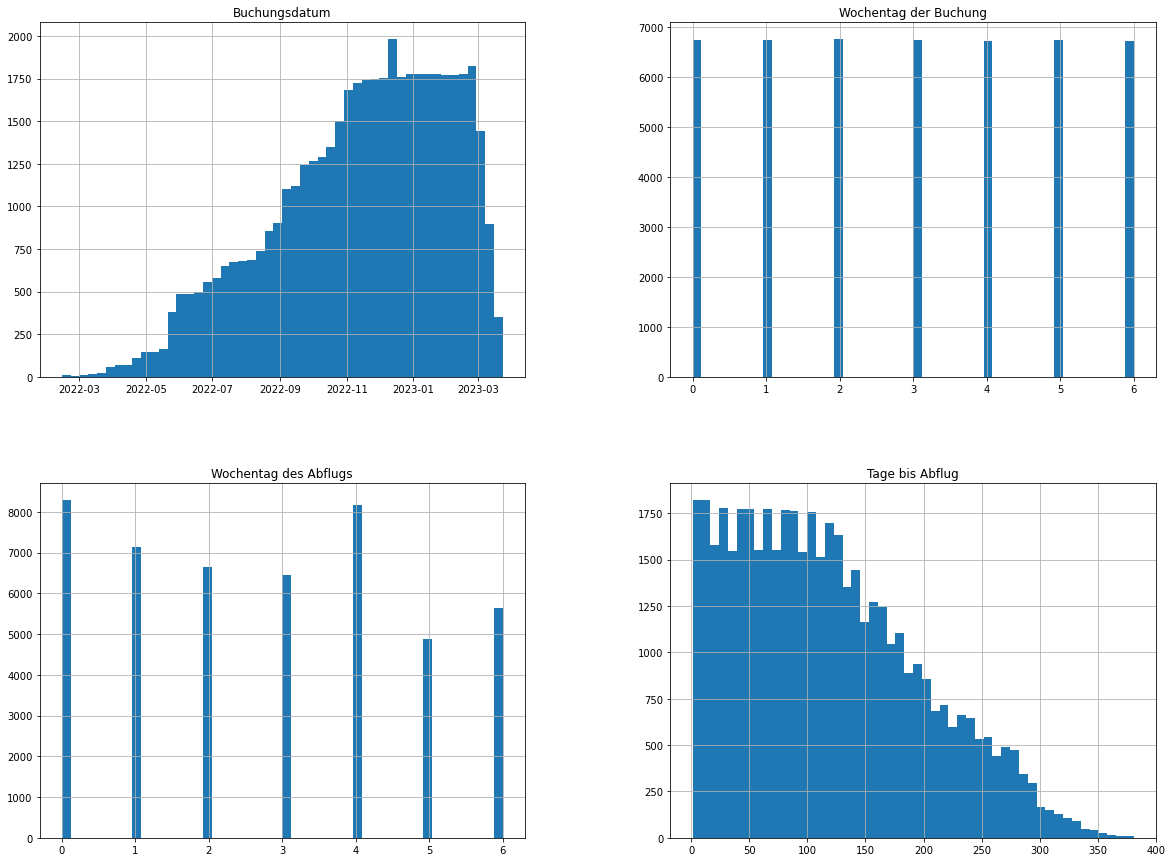

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

df[["Buchungsdatum", "Wochentag der Buchung", "Wochentag des Abflugs", "Tage bis Abflug"]].hist(bins=50, figsize=(20,15))
plt.show()

In [16]:
df.head()

,Buchungsdatum,Abflugdatum,Abflughafen,Zielflughafen,Abflugzeit,Ankunftszeit,Preis,Flugnummer,Airline,Wochentag der Buchung,Wochentag des Abflugs,Tage bis Abflug
0,2022-11-09,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,2,6,109
1,2022-11-10,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,3,6,108
2,2022-11-11,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,4,6,107
3,2022-11-12,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,5,6,106
4,2022-11-13,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,6,6,105


Auffälligkeiten:
- Buchungsdatum: Die meisten Preise wurden im Zeitraum 11/2022 bis 03/2023 aufgezeichnet.Je früher der Zeitraum ist, desto weniger Flugpreise sind vorhanden.
- Wochentag der Buchung: Die Wochentage sind ziemlich gleich verteilt. Es gibt keine Ausprägung, die besonders häufig auftritt.
- Wochentag des Abflugs: Offensichtlich gibt es an Montagen und Freitagen die meisten Flugpreise. Dies kann einerseits daran liegen, dass an diesen Tagen vermehrt Flüge angeboten werden, oder, dass einfach die meisten Flugpreise an diesen Tagen erfasst wurden. Dies wird im Folgenden geprüft.
- Tage bis Abflug: Die meisten Flugpreise liegen für die Zeit ab ca. 150 Tage vor Abflug vor. 

## 3.5. Untersuchung der Wochentage <a class="anchor" id="wochentage"></a>

Wie zuvor genannt, sollen die Wochentage des Abflugs genauer untersucht werden. Hierfür wird zunächst der Datensatz gruppiert, indem nicht die Anzahl verfügbarerer Preise pro Wochentag angezeigt werden, sondern die tatsächliche Anzahl an Flügen pro Wochentag. Dies wird anschließend visualisiert.

In [17]:
#Datensatz gruppieren, um einzelne Flüge zusammenzufassen. Der Wochentag wird beibehalten.
gruppiert = df[["Abflugdatum", "Flugnummer", "Wochentag des Abflugs"]].groupby(["Abflugdatum", "Flugnummer"])
df_2 = gruppiert.first()

In [18]:
df_2.head()

Wochentag des Abflugs
Abflugdatum Flugnummer                       
2023-02-26  BA 967                          6
            EW 7460                         6
            EW 7462                         6
2023-02-27  BA 957                          0
            BA 963                          0

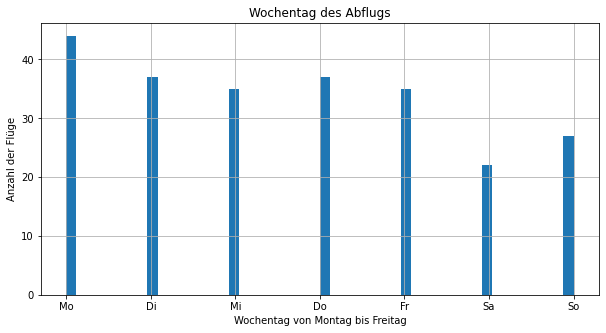

In [19]:
#Plotten der Anzahl der Flüge an verschiedenen Wochentagen
ax = df_2[["Wochentag des Abflugs"]].hist(bins=50, figsize=(10,5))
ax = ax[0]

for x in ax:
    x.set_xlabel("Wochentag von Montag bis Freitag")
    x.set_ylabel("Anzahl der Flüge")
    x.set_xticks([0,1,2,3,4,5,6],["Mo","Di", "Mi", "Do", "Fr", "Sa", "So"])

Nun wird ersichtlich, dass an Montagen tatsächlich die meisten Flüge stattfinden. Zudem finden am Wochenende generell weniger Flüge statt, wobei samstags die wenigsten Flüge angeboten werden. Aber wie verhält es sich an den verschiedenen Tagen des Abflugs mit den Preisen? Für diese Frage wird der durchschnittliche Flugpreis für die sieben Wochentage angegeben.

In [20]:
#Gruppieren nach Wochentag des Abflugs und anschließende Berechnung des durchschnittlichen Preises
df_3 = df[["Wochentag des Abflugs", "Preis"]].groupby(["Wochentag des Abflugs"])["Preis"].mean().reset_index()
display(df_3)

,Wochentag des Abflugs,Preis
0,0,73.282645
1,1,56.166409
2,2,62.999849
3,3,77.709642
4,4,88.885375
5,5,107.064887
6,6,85.713045


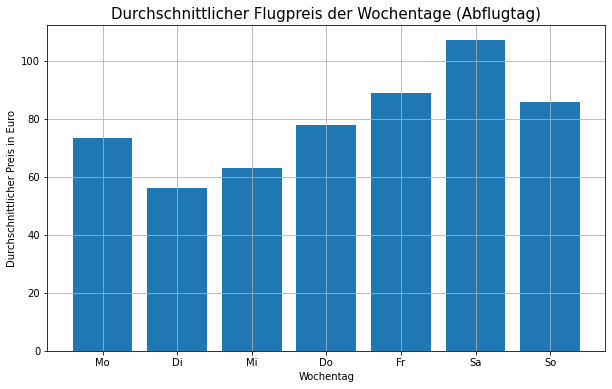

In [21]:
#Speichern der Werte in Listen, um anschließend zu plotten, da nach Groupby .hist() nicht möglich ist
x = df_3["Wochentag des Abflugs"]
y = df_3["Preis"]
map_liste = ["Mo","Di", "Mi", "Do", "Fr", "Sa", "So"]

#Plotten der Ergebnisse
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Durchschnittlicher Flugpreis der Wochentage (Abflugtag)", size=15)

ax.bar(x, y)

ax.set_ylabel("Durchschnittlicher Preis in Euro", size=10)
ax.set_xlabel("Wochentag", size=10)
ax.set_xticks(x, map_liste)
plt.grid()

Offensichtlich sind Flüge mit Abflug am Dienstag am günstigsten, während Flüge an Samstagen am teuersten sind. Wie verhält es sich aber mit dem Wochentag der Buchung?

In [22]:
#Gruppieren nach Wochentag der Buchung und anschließende Berechnung des durchschnittlichen Preises
df_4 = df[["Wochentag der Buchung", "Preis"]].groupby(["Wochentag der Buchung"])["Preis"].mean().reset_index()
display(df_4)

,Wochentag der Buchung,Preis
0,0,77.114222
1,1,77.404148
2,2,78.017759
3,3,77.764881
4,4,77.132768
5,5,77.543862
6,6,77.701783


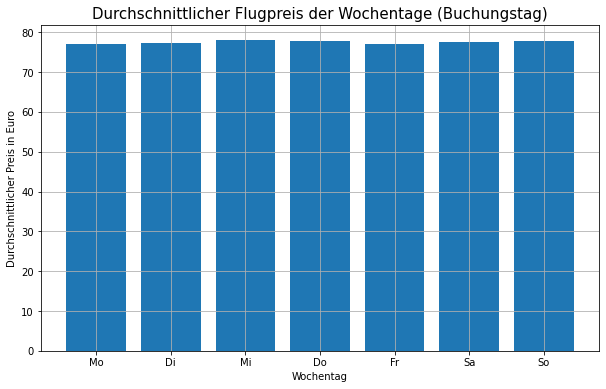

In [23]:
#Speichern der Werte in Listen, um anschließend zu plotten, da nach Groupby .hist() nicht möglich ist
x = df_4["Wochentag der Buchung"]
y = df_4["Preis"]

#Plotten der Ergebnisse
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Durchschnittlicher Flugpreis der Wochentage (Buchungstag)", size=15)

ax.bar(x, y)

ax.set_ylabel("Durchschnittlicher Preis in Euro", size=10)
ax.set_xlabel("Wochentag", size=10)
ax.set_xticks(x, map_liste)
plt.grid()

Offensichtlich hat der Wochentag der Buchung (bezogen auf den Datensatz) keinen nennenswerten Einfluss auf den Flugpreis. Im Rahmen der Datenvorverarbeitung muss geprüft werden, ob dieses Attribut ggf. wieder entfernt werden sollte, wenn es tatsächlich keinen Einfluss auf den Preis haben sollte.

## 3.6. Untersuchung des Preisverhaltens im Zeitverlauf <a class="anchor" id="preisverhalten"></a>

Als nächstes soll untersucht werden, wie sich der Preis im Zeitverlauf ändert. Sind Flüge kurz vor Abflug teurer? Sind weit im Voraus gebuchte Flüge günstiger? In welchem Zeitraum ist ein Flug durchschnittlich am günstigsten?

In [24]:
#Diese Funktion bekommt einen Datensatz übergeben und optional eine Airline.
#Anschließend wird entweder für alle Flüge oder für eine bestimmte Airline der günstigste Preis
#bestimmt und ausgegeben. Für "tage" kann das Zeitfenster eingeschränkt werden,
#es wird der höchste Tag (int) angegeben. 
#Anschließend wird der Preisverlauf und eine rote Grenze graphisch dargestellt.
#Die Grenze liegt 25% über dem günstigsten durchschnittlichen Preis liegt. 

def analysiere_preise(data, airline="None", tage="None"):
    
    #ggf. Airline und ggf. zusätzlich die Tage selektieren
    if(airline != "None"):
        airline_data = data[data["Airline"] == airline]
        airline_data_mean = airline_data[["Tage bis Abflug", "Preis"]].groupby(["Tage bis Abflug"])["Preis"].mean().reset_index()
        airline_data_std = airline_data[["Tage bis Abflug", "Preis"]].groupby(["Tage bis Abflug"])["Preis"].std().reset_index()
        
        if(tage != "None"):
            airline_data = airline_data[airline_data["Tage bis Abflug"] <= tage]
            airline_data_mean = airline_data[["Tage bis Abflug", "Preis"]].groupby(["Tage bis Abflug"])["Preis"].mean().reset_index()
            airline_data_std = airline_data[["Tage bis Abflug", "Preis"]].groupby(["Tage bis Abflug"])["Preis"].std().reset_index()
    
    #ggf. nur Tage selektieren
    elif(tage != "None"):
        airline_data = data[data["Tage bis Abflug"] <= tage]
        airline_data_mean = airline_data[["Tage bis Abflug", "Preis"]].groupby(["Tage bis Abflug"])["Preis"].mean().reset_index()    
        airline_data_std = airline_data[["Tage bis Abflug", "Preis"]].groupby(["Tage bis Abflug"])["Preis"].std().reset_index()
    
    #Datensatz wird nach der Anzahl der Tage vor Abflug gruppiert, um den 
    #durchschnittlichen Tagespreis zu erhalten
    else:
        airline_data_mean = data[["Tage bis Abflug", "Preis"]].groupby(["Tage bis Abflug"])["Preis"].mean().reset_index()
        airline_data_std = data[["Tage bis Abflug", "Preis"]].groupby(["Tage bis Abflug"])["Preis"].std().reset_index()
    
    guenstigster_preis_mean = airline_data_mean["Preis"].min()
    
    #Ausgabe
    print("Günstigster durchschnittlicher Preis: ", guenstigster_preis_mean, " Euro")
    
    #Bestimmung der x- und y-Werte für graphische Darstellung
    x_mean = airline_data_mean["Tage bis Abflug"]
    y_mean = airline_data_mean["Preis"]
    
    x_std = airline_data_std["Tage bis Abflug"]
    y_std = airline_data_std["Preis"]
    
    #Nun sollen Grenzen günstiger Flüge bestimmt werden: Hierfür wird der günstigste Preis um 25% erhöht
    grenze_mean = [airline_data_mean["Preis"].min()*1.25]*len(x_mean)

    #Plotten der Ergebnisse
    fig, axes = plt.subplots(1,2, figsize=(20,7))
    axes[0].set_title("Durchschnittlicher Flugpreis im Zeitverlauf", size=15)
    axes[0].plot(x_mean, y_mean, label="Durchschnittlicher Flugpreis")
    axes[0].plot(x_mean, grenze_mean, color="red", label="Günstigster Flug + 25%")
    axes[0].set_ylabel("Durchschnittlicher Preis in Euro", size=10)
    axes[0].set_xlabel("Tage bis Abflug", size=10)
    axes[0].legend()
    axes[0].grid()
    
    axes[1].set_title("Standardabweichung im Zeitverlauf", size=15)
    axes[1].plot(x_std, y_std)
    axes[1].set_ylabel("Standardabweichung in Euro", size=10)
    axes[1].set_xlabel("Tage bis Abflug", size=10)
    axes[1].grid()

Im Folgenden werden nun einige Grafiken dargestellt. Links ist immer der durchschnittliche Preis in Euro in Abhängigkeit der Anzahl der Tage bis zum Abflug dargestellt. Da es sich um Durchschnittswerte handelt, ist es sinnvoll, sich parallel die Standardabweichung anzuschauen (rechte Grafik). Eine hohe Standardabweichung deutet darauf hin, dass die einzelnen Werte insgesamt deutlich vom Durchschnitt abweichen können. Bei einer niedrigen Standardabweichung kann davon ausgegangen werden, dass der Durchschnittswert ungefähr den tatsächlichen einzelnen Werten entspricht.

Zudem ist im linken Graphen eine Grenze in rot eingezeichnet. Hierbei handelt es sich um den um 25% erhöhten günstigsten Preis im Zeitverlauf. Alle Preise unterhalb dieser Grenze gehören zu dem Viertel der günstigsten durchschnittlichen Preise.

Günstigster durchschnittlicher Preis:  45.9375  Euro


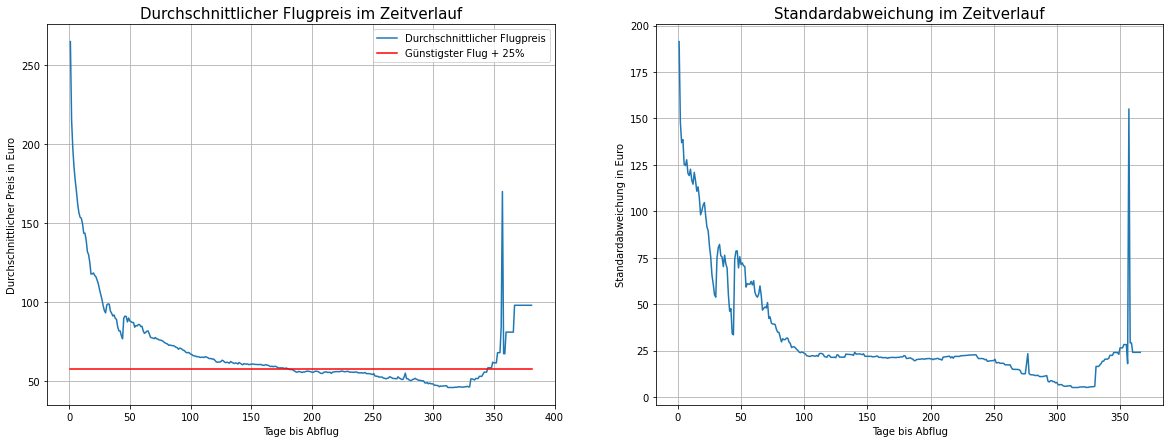

In [25]:
#Preisverlauf für den gesamten Datensatz
analysiere_preise(df)

Man erkennt, dass eine frühe Buchung im Durchschnitt günstiger ist. Einen günstigen Preis erreicht man durch eine Buchung zwischen 200 und 350 Tagen vor Abflug (bezogen auf **alle** Airlines). 

Da allerdings in der Zeit von ca. 140 bis 381 Tage vor Abflug deutlich weniger Daten zur Verfügung stehen, ist es sinnvoll, den Zeitverlauf einzuschränken und diesen einzeln zu betrachten. Daher wird nun der Zeitverlauf auf 140 Tage bis 1 Tag vor Abflug eingegrenzt. 

Günstigster durchschnittlicher Preis:  60.80107526881721  Euro


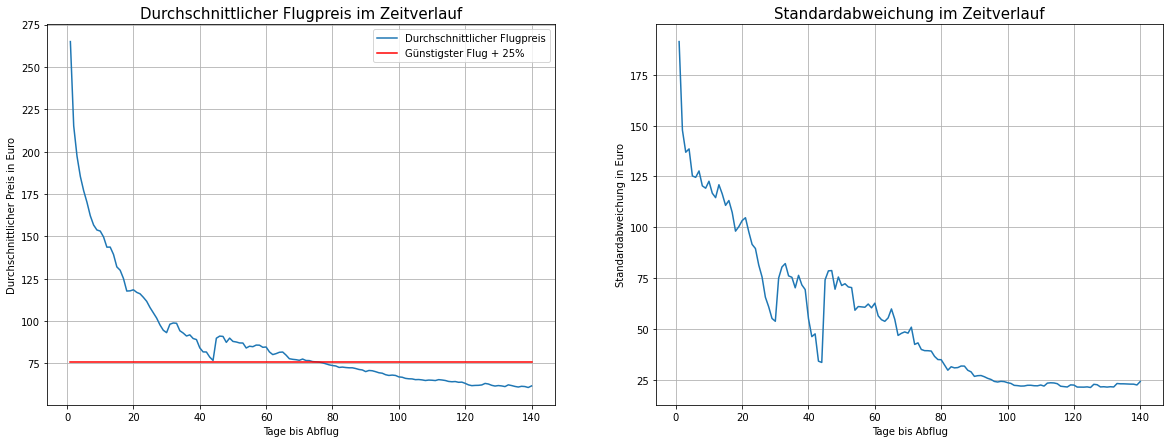

In [26]:
#Preisverlauf für 140 Tage bis 1 Tag vor Abflug
analysiere_preise(df, tage=140)

Auch hier ist ein klarer Trend zu erkennen. Je näher das Abflugdatum kommt, desto teurer wird im Schnitt der Flug. 120 bis 140 Tage vor Abflug ist der Preis am günstigsten und hier liegt auch eine geringe Standardabweichung vor, was auf einen guten Buchungszeitraum hindeuten könnte.

Da es sich nur um Durchschnittswerte des gesamten Datensatzes handelt, ist es sinnvoll, sich die einzelnen Airlines genauer anzusehen. Daher wird nachfolgend die soeben erläuterte Grafik für jede Airline dargestellt.

Airline: Eurowings
Günstigster durchschnittlicher Preis:  40.0  Euro


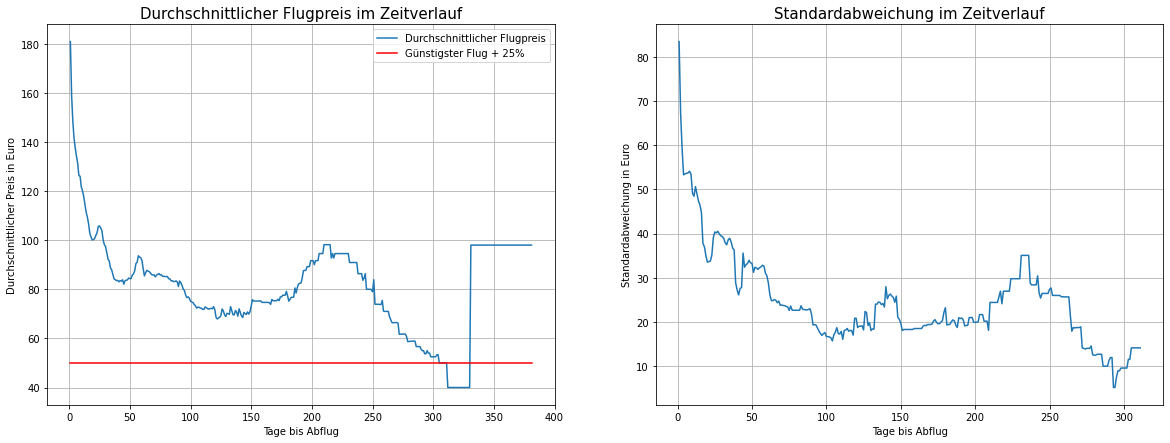

In [27]:
print("Airline: Eurowings")
analysiere_preise(df, airline="Eurowings")

Airline: British Airways
Günstigster durchschnittlicher Preis:  45.0  Euro


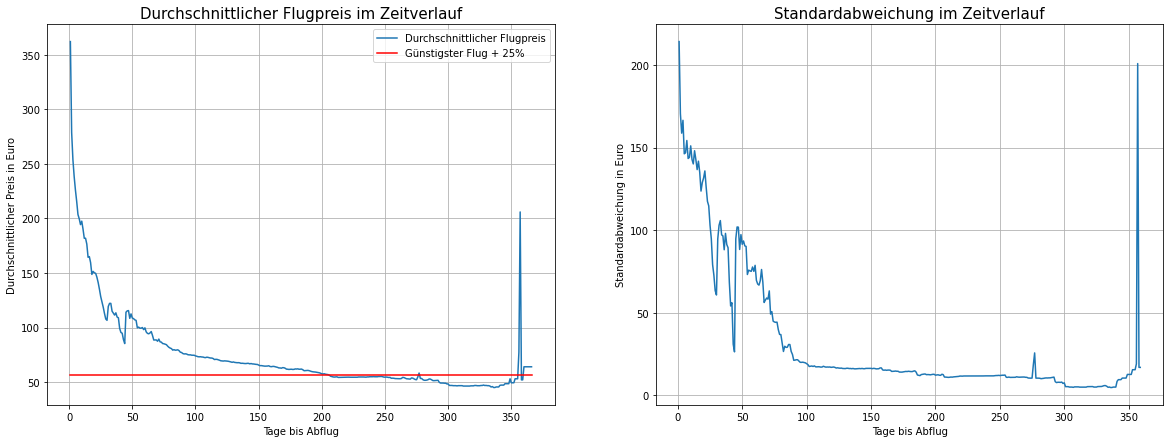

In [28]:
print("Airline: British Airways")
analysiere_preise(df, airline="British Airways")

Airline: easyJet
Günstigster durchschnittlicher Preis:  38.0  Euro


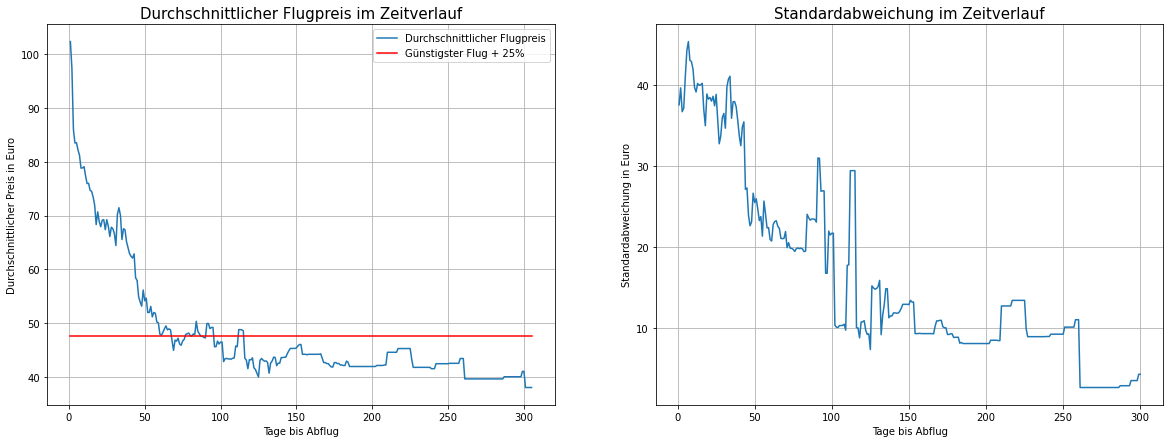

In [29]:
print("Airline: easyJet")
analysiere_preise(df, airline="easyJet")

Airline: Ryanair
Günstigster durchschnittlicher Preis:  24.85  Euro


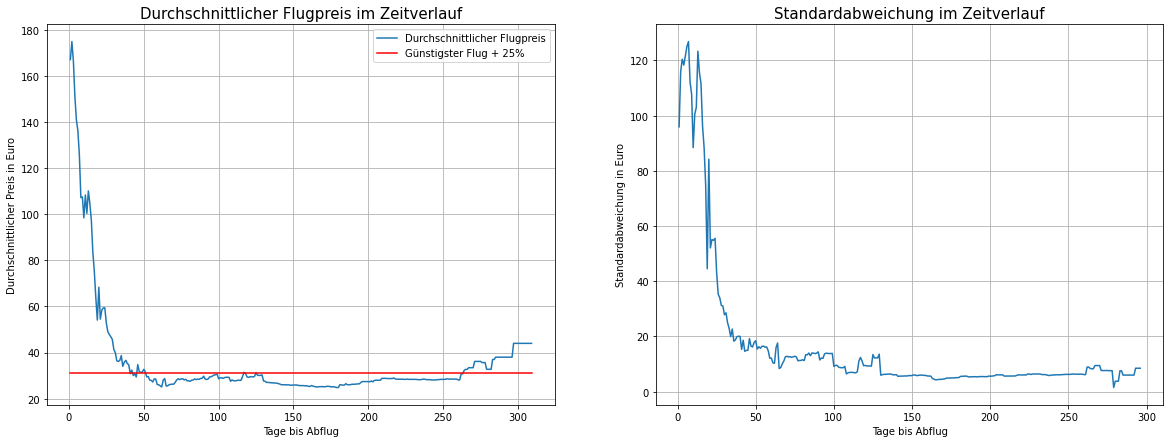

In [30]:
print("Airline: Ryanair")
analysiere_preise(df, airline="Ryanair")

**Erkenntnisse:**

Eurowings: 
- günstige Preise ca. 330-300 Tage vor Abflug
- ab 300 Tagen vor Abflug beginnt der Preis anzusteigen
- anschließend folgt eine günstigere Phase zwischen 150 und 90 Tagen vor Abflug, wobei die 25%-Grenze nicht mehr unterschritten wird
- insgesamt gibt es nur wenige Flugpreise, die die 25%-Grenze unterschreiten, ggf. handelt es sich daher bei dem günstigsten Preis um einen Ausreißer
- ab 10 Tagen vor Abflug steigen die Preise deutlich an

British Airways:
- günstige Preise ca. 350-200 Tage vor Abflug
- danach stetiger Anstieg des Preises
- ab 60 Tagen vor Abflug ist eine deutlich erhöhte Standardabweichung zu erkennen, was auf extreme Schwankungen und einen nicht repräsentativen Durchschnittswert hindeutet
- ab 25 Tagen vor Abflug steigen die Preise schnell und stark an

easyJet:
- günstige Preise ca. 300-60 Tage vor Abflug
- die Tenzend ist durchgehend leicht steigend, je näher der Abflug kommt, allerdings wird dieser Anstieg durch ständige Schwankungen begleitet
- ab 50 Tagen vor Abflug ist ein deutlicher stetiger Anstieg zu erkennen, wobei auch dieser stark schwankt

Ryanair:
- günstige Preise ca. 260-60 Tage vor Abflug
- bei mehr als 260 Tagen vor Abflug sind die Flüge teurer
- ab 20 Tagen vor Abflug ist ein deutlicher Ansteig zu erkennen, wobei auch die Standardabweichung sehr ansteigt. Die Preise schwanken demnach und der Durchschnittswert ist nicht repräsentativ

## 3.7. Korrelationen <a class="anchor" id="korrelation"></a>

Zum Abschluss der explorativen Datenanalyse sollen noch die Korrelationen zwischen den einzelnen Merkmalen bestimmt werden. Hierfür wird der Pearson-Korrelationskoeffizient verwendet, ein Maß für die lineare Beziehung zwischen zwei Variablen. Der Korrelationskoeffizient nimmt einen Wert zwischen -1 und 1 an. Für diesen Wert gilt:
- 1 weist auf eine starke positive Korrelation hin
- 0 weist auf keine Korrelation hin
- -1 weist auf eine starke negative Korrelation hin

In [31]:
df.corr()

,Preis,Wochentag der Buchung,Wochentag des Abflugs,Tage bis Abflug
Preis,1.000000,0.001322,0.175157,-0.362053
Wochentag der Buchung,0.001322,1.000000,-0.003340,-0.001697
Wochentag des Abflugs,0.175157,-0.003340,1.000000,0.054411
Tage bis Abflug,-0.362053,-0.001697,0.054411,1.000000


Da es sich bei der Airline um ein nominales Attribut handelt, wurde dieses bei der Bestimmung der Korrelationen nicht berücksichtigt. Um dieses wichtige Attribut zu berücksichtigen, wird eine neue Spalte mit dem Airline-Code hinzugefügt, der die Airline wie folgt codiert:
- 0: British Airways
- 1: Eurowings
- 2: easyJet
- 3: Ryanair

Hierbei wurde die Reihenfolge so gewählt, dass die teuerste Airline zu Beginn mit 0 aufgeführt wird. Je höher die Codierung der Airline ist, desto günstiger ist die Airline im Allgemeinen. Dies ist wichtig, um ggf. eine Korrelation erkennen zu können.

In [32]:
df_airlinecode = df.copy()
airline_map = {
    "British Airways": 0,
    "Eurowings": 1,
    "easyJet": 2,
    "Ryanair": 3
}

df_airlinecode["Airlinecode"] = df_airlinecode["Airline"].map(airline_map)
df_airlinecode

,Buchungsdatum,Abflugdatum,Abflughafen,Zielflughafen,Abflugzeit,Ankunftszeit,Preis,Flugnummer,Airline,Wochentag der Buchung,Wochentag des Abflugs,Tage bis Abflug,Airlinecode
0,2022-11-09,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,2,6,109,1
1,2022-11-10,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,3,6,108,1
2,2022-11-11,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,4,6,107,1
3,2022-11-12,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,5,6,106,1
4,2022-11-13,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,6,6,105,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47226,2023-03-22,2023-03-25,HAM,LHR,15:20:00,16:05:00,550,BA 975,British Airways,2,5,3,0
47227,2023-03-23,2023-03-25,HAM,LHR,15:20:00,16:05:00,550,BA 975,British Airways,3,5,2,0
47228,2023-03-24,2023-03-25,HAM,LHR,07:20:00,08:10:00,370,EW 7464,Eurowings,4,5,1,1
47229,2023-03-24,2023-03-25,HAM,LHR,15:20:00,16:05:00,340,BA 975,British Airways,4,5,1,0


Nun soll auch die Abflugzeit berücksichtigt werden. Hierfür wird eine neue Spalte eingefügt, die das Zeitfenster das Abfluges bestimmt. Es wird in fünf Zeitfenster eingeteilt (aufgrund des Nachtflugverbotes in Hamburg finden zwischen 23 und 6 Uhr keine Flüge statt):
- früh morgens: 0 bis 8 Uhr
- morgens: 8 bis 11 Uhr
- mittags: 11 bis 14 Uhr
- nachmittags: 14 bis 18 Uhr
- abends: 18 bis 0 Uhr

Diese Zeitfenster werden wie folgt codiert:
- 0: früh morgens
- 1: morgens
- 2: mittags
- 3: nachmittags
- 4: abends

In [33]:
#Funktion zur Konvertierung definieren
def konvertiere_abflugzeit(abflugzeit):
    #Zeitgrenzen definieren
    frueh_morgens = time(8,0,0)
    morgens = time(11,0,0)
    mittags = time(14,0,0)
    nachmittags = time(18,0,0)
    abends = time(23,59,0)
    
    if(abflugzeit < frueh_morgens):
        return 0
    elif(abflugzeit < morgens):
        return 1
    elif(abflugzeit < mittags):
        return 2
    elif(abflugzeit < nachmittags):
        return 3
    elif(abflugzeit < abends):
        return 4
    else:
        #Fehlercode, sollte aber nicht vorkommen
        return 999

#Wende die Funktion auf die Abflugzeit an
df_airlinecode["Abflugzeit codiert"] = df_airlinecode["Abflugzeit"].apply(konvertiere_abflugzeit)

Zuletzt soll auch der Zielflughafen codiert werden, um die Korrelation zu bestimmen. Der Abflughafen bleibt außer Acht, da es sich hierbei nur um den Flughafen Hamburg handelt.

Die Codierung erfolgt folgendermaßen:
- 0: Flughafen LHR
- 1: Flughafen LGW
- 2: Flughafen STN

In [34]:
#Funktion zur Codierung des Flughafens
def konvertiere_flughafen(flughafen):
    if(flughafen == "LHR"):
        return 0
    elif(flughafen == "LGW"):
        return 1
    elif(flughafen == "STN"):
        return 2
    #Ansonsten Fehlercode
    else:
        return 999
    
#Wende die Funktion auf den Zielflughafen an
df_airlinecode["Zielflughafen codiert"] = df_airlinecode["Zielflughafen"].apply(konvertiere_flughafen)
df_airlinecode

,Buchungsdatum,Abflugdatum,Abflughafen,Zielflughafen,Abflugzeit,Ankunftszeit,Preis,Flugnummer,Airline,Wochentag der Buchung,Wochentag des Abflugs,Tage bis Abflug,Airlinecode,Abflugzeit codiert,Zielflughafen codiert
0,2022-11-09,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,2,6,109,1,3,0
1,2022-11-10,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,3,6,108,1,3,0
2,2022-11-11,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,4,6,107,1,3,0
3,2022-11-12,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,5,6,106,1,3,0
4,2022-11-13,2023-02-26,HAM,LHR,17:55:00,18:40:00,98,EW 7460,Eurowings,6,6,105,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47226,2023-03-22,2023-03-25,HAM,LHR,15:20:00,16:05:00,550,BA 975,British Airways,2,5,3,0,3,0
47227,2023-03-23,2023-03-25,HAM,LHR,15:20:00,16:05:00,550,BA 975,British Airways,3,5,2,0,3,0
47228,2023-03-24,2023-03-25,HAM,LHR,07:20:00,08:10:00,370,EW 7464,Eurowings,4,5,1,1,0,0
47229,2023-03-24,2023-03-25,HAM,LHR,15:20:00,16:05:00,340,BA 975,British Airways,4,5,1,0,3,0


In [35]:
df_airlinecode.corr()

,Preis,Wochentag der Buchung,Wochentag des Abflugs,Tage bis Abflug,Airlinecode,Abflugzeit codiert,Zielflughafen codiert
Preis,1.000000,0.001322,0.175157,-0.362053,-0.249549,-0.143292,-0.271884
Wochentag der Buchung,0.001322,1.000000,-0.003340,-0.001697,-0.000144,0.000729,0.000400
Wochentag des Abflugs,0.175157,-0.003340,1.000000,0.054411,-0.039935,-0.044279,-0.012897
Tage bis Abflug,-0.362053,-0.001697,0.054411,1.000000,-0.074541,-0.018014,-0.005899
Airlinecode,-0.249549,-0.000144,-0.039935,-0.074541,1.000000,0.490138,0.903079
Abflugzeit codiert,-0.143292,0.000729,-0.044279,-0.018014,0.490138,1.000000,0.533411
Zielflughafen codiert,-0.271884,0.000400,-0.012897,-0.005899,0.903079,0.533411,1.000000


Bezogen auf den Preis fällt folgendes auf:
- Der Wochentag der Buchung hat eine Korrelation von 0.001. Dies deutet darauf hin, dass kein Zusammenhang zwischen den beiden Attributen besteht. Dies bestätigt auch schon die vorherige Vermutung.
- Der Wochentag des Abflugs hat eine Korrelation von 0.18. Die Korrelation ist zwar gering, aber ein Zusammenhang besteht.
- Die Anzahl der Tage vor Abflug hat, wie erwartet, die höchste (negative) Korrelation mit -0.36. Das bedeutet, je höher die Anzahl der Tage bis Abflug, desto niedriger ist der Preis. Dies kann natürlich auch andersherum betrachtet werden: Je niedriger die Anzahl der Tage bis Abflug, desto höher ist der Preis.
- Die Airline selbst (in diesem Fall die codierte Airline) hat ebenfalls einen Einfluss auf den Flugpreis, was durch eine negative Korrelation von -0.25 ersichtlich ist. Die Codierung wurde so gewählt, dass die Airlines von "herkömmlicher Airline" nach "Billigairline" absteigend sortiert wurden (0: British Airways, 1: Eurowings, 2: easyJet, 3: Ryanair). Je höher also der Code ist, desto eher handelt es sich um eine Billigairline und umso niedriger ist der Preis. 
- Die Abflugzeit hat eine geringe negative Korrelation von -0.14. Demnach hat sie zwar Einfluss auf den Preis, allerdings ist dieser gering. Auffällig ist hier, dass die Abflugzeit mit dem Airlinecode korreliert, je später der Abflug ist, desto eher handelt es sich um eine Billigfluggesellschaft und dementsprechend günstiger ist auch der Flug.
- Der Zielflughafen hat eine negative Korrelation von -0.27. Dies bedeutet, dass der Preis umso niedriger wird, je abgelegener der Flughafen ist. Dies ist auch nachvollziehbar, da die Billigfluggesellschaften die abgelegenen Flughäfen anfliegen.

Die Anzahl der Tage bis Abflug, die Airline und der Zielflughafen haben demnach das größte Potenzial, um zur Vorhersage von Flugpreisen herangezogen zu werden.

## 3.8. Graphische Übersicht <a class="anchor" id="grafik"></a>

Es werden zum Abschluss alle Datenpunkte einer Airline jeweils in einem Graphen abgebildet. Dies erscheint zunächst unübersichtlich, gibt aber dennoch eine gute Übersicht der vier Airlines und der Verteilung der Preise. Zudem sind Ausreißer erkennbar (insbesondere die British Airways-Flüge über 600 Euro).

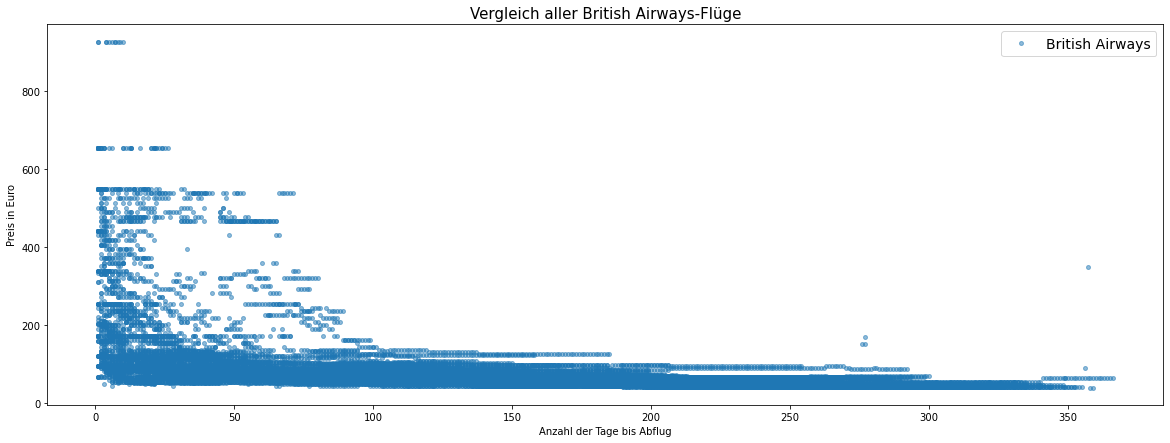

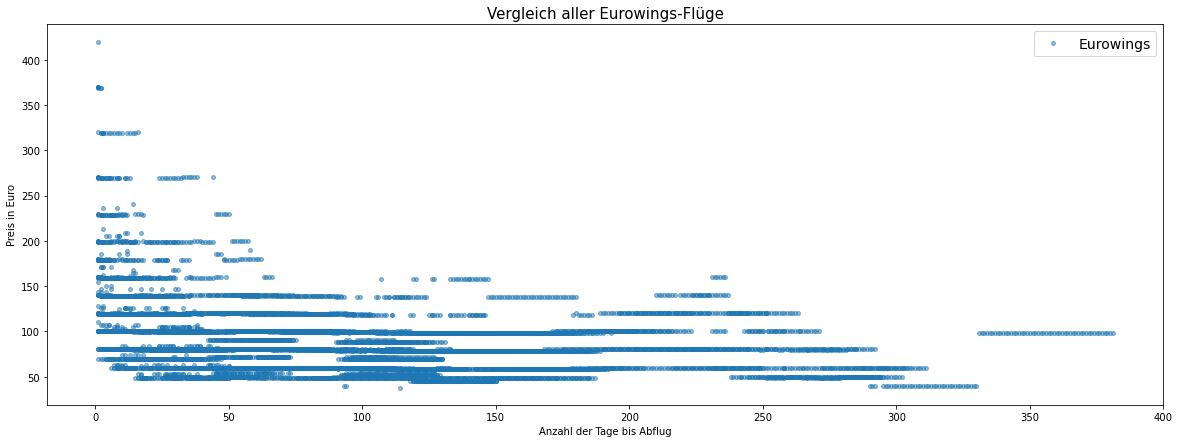

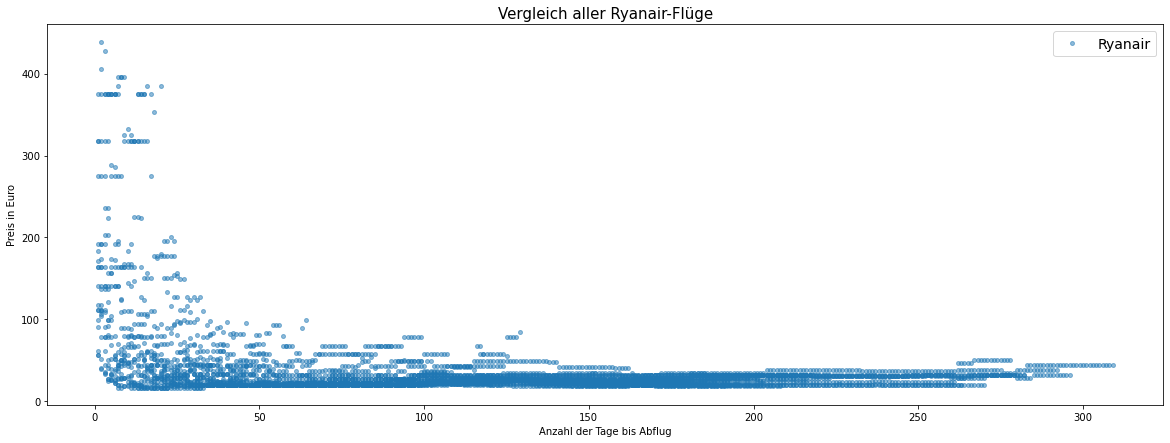

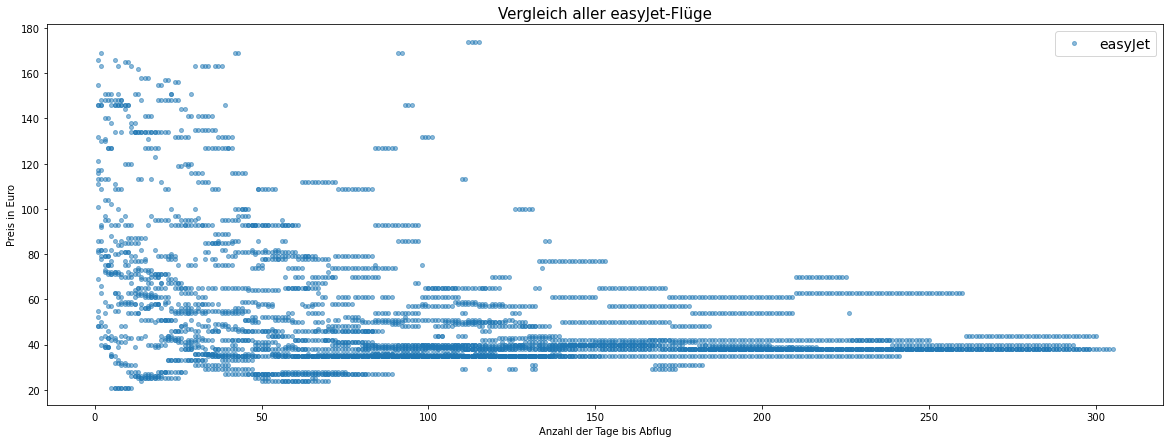

In [67]:
gruppen = df.groupby("Airline")


for name, gruppe in gruppen:
    fig, ax = plt.subplots(figsize=(20,7))
    ax.plot(gruppe["Tage bis Abflug"], gruppe["Preis"], marker='o', linestyle='', markersize=4,label=name,
           alpha=0.5)
    ax.set_title("Vergleich aller " + name + "-Flüge", size=15)
    ax.set_ylabel("Preis in Euro", size=10)
    ax.set_xlabel("Anzahl der Tage bis Abflug", size=10)
    plt.legend(prop={"size": 14})
    plt.show()